In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First of all, we get the data from csv file. (expected return and covariance matrix)

In [368]:
Eret = pd.read_csv("expected_return.csv").values
covariance = pd.read_csv("covariance_matrix.csv").values

This is the class of each particle which has it's position, velocity, force from other particles and acceleration.

In [369]:
class particle:
    def __init__(self, arr, vel):
        self.pos = np.array(arr)
        self.velocity = np.array(vel)
        self.force = np.zeros(10)
        self.a = np.zeros(10)

We are looking to minimize the function:

$$ x^TCx - \beta x^T\mu$$

which $x^T$ is x array, C is the covariance matrix and $\mu$ is the Eret.

In [370]:
def fitness(x, beta):
    return -(x@covariance@np.transpose(x) - beta*(x*Eret).sum())

This is the check function which map each array to another array which it's some is equal to 1 and all of it's elements are non-negative

In [371]:
def check(arr):
    arr_sum = sum(arr)
    normalized_arr = [max(0, float(element) / arr_sum) for element in arr]
    new_sum = sum(normalized_arr)
    normalized_arr = [element / new_sum for element in normalized_arr]
    
    return np.array(normalized_arr)

This function calcaulate the Mass array which is:
$$ M_i(t) = \frac{m_i(t)}{\sum_{j=1}^{N}m_j(t)}$$

In [372]:
def cal_Mass(arr_m):
    sumation = arr_m.sum()
    arr_M = np.zeros(len(arr_m))
    for i in range(len(arr_m)):
        arr_M[i] = arr_m[i]/(sumation - arr_m[i])
    return arr_M

This function calculates the m array which is:
$$\frac{fit_i(t) - worst(t)}{best(t) - worst(t)}$$
where,
$ best(t) = \max fit_i(t)$ and $worst(t) = \min fit_i(t)$


In [373]:
def cal_m(arr_fit, w, b):
    arr_m = np.zeros(len(arr_fit))
    for i in range(len(arr_fit)):
        arr_m = (arr_fit - w)/(b - w)
    return arr_m

This function, calculates G which is equal to:
$$G(t) = G_0e^{\frac{-\alpha t}{T}}$$
in generation t

In [374]:
def cal_G(iteration, total_iteration, G0, alpha):
    return G0*np.exp(-alpha*iteration/total_iteration)

This is the force calculator:
$$ F_{ij} = G(t) \times \frac{Mass_i(t) \times Mass_j(t)}{R_{ij}(t) + \epsilon} (x_j(t) - x_i(t)) $$

In [375]:
def cal_force(arr_M, particles, iteration, total_iteration, G0, alpha):
    for i in range(len(arr_M)):
        for j in range(len(arr_M)):
            if (i!=j or (particles[i].pos - particles[j].pos).sum() < 1e-5):
                particles[i].force += np.random.rand(1)*cal_G(iteration, total_iteration, G0, alpha)*(arr_M[i]*arr_M[j]/(np.sqrt(((particles[i].pos - particles[j].pos)**2).sum()) + np.random.rand(1)))*(particles[j].pos - particles[i].pos)

This is the main algorithm:
>First of all, we make the initial population

>After that for each particle, we calculate the force

>the the acceleration

>And after that, we update the velocity

>And it's position
We do this for iteration times and then return the best position

In [376]:
def gravity(n, total_iteration, G0, alpha, beta):
    np.random.seed(100)
        
    particles = [particle([np.random.uniform(0, 0.1) for i in range(10)], [np.random.uniform(-0.5, 0.5) for i in range(10)]) for i in range(n)]
        
    worst = 1000
    best = -1000
            
    best_arr = np.array([])
    all_time_best = -1000
    
    for i in range(total_iteration):
        for k in range(n):
            particles[k].pos = check(particles[k].pos)
            
        arr_fit = np.array([fitness(particles[k].pos, beta) for k in range(len(particles))])
        
        for k in range(len(particles)):
            if (arr_fit[k] > best):
                best = arr_fit[k]
            elif (arr_fit[k] < worst):
                worst = arr_fit[k]
            
            if (best > all_time_best):
                all_time_best = best
                all_time_best_pos = particles[k].pos
                
        best_arr = np.append(best_arr, best)
        
        arr_m = cal_m(arr_fit, worst, best)
        arr_M = cal_Mass(arr_m)
        cal_force(arr_M, particles, i, total_iteration, G0, alpha)
        for j in range(n):
            if (arr_M[j] != 0):
                particles[j].a = particles[j].force/arr_M[j]
            else:
                particles[j].a = np.zeros(10)
        
        for j in range(n):
            particles[j].velocity = np.random.rand(1)*particles[j].velocity + particles[j].a
            particles[j].pos += particles[j].velocity
            
    return best_arr, check(all_time_best_pos)

Finally this is a test for our algorithm:

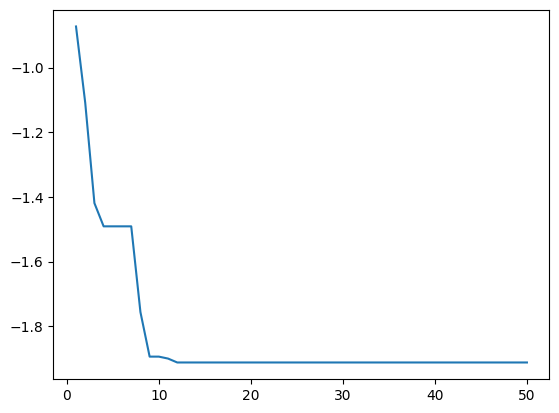

In [377]:
num_ite = 50
arr, pos = gravity(10, num_ite, 100, 1, 100)
ite = [i+1 for i in range(num_ite)]
plt.plot(ite, -arr)
plt.show()

In [378]:
pos

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10781056, 0.89218944, 0.        , 0.        ])

In [379]:
(pos*Eret).sum()

0.018181128017986273

In [380]:
pos@covariance@np.transpose(pos)

0.010580238343764285